# ALY 6140 - Final Presentation
# Classification Report: Predicting Crime Severity

In [413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer



Loading the Dataset

In [414]:
crime = pd.read_csv("Crime_Data_from_2020_to_Present.csv")
print(crime.shape)



(1112545, 28)


In [415]:
crime.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


In [416]:
crime.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [417]:
# Data cleaning

crime = crime.drop_duplicates()
print(crime.shape)

crime['AREA'] = pd.to_numeric(crime['AREA'], errors='coerce')
print(crime['AREA'].dtype)



(881775, 28)
int64


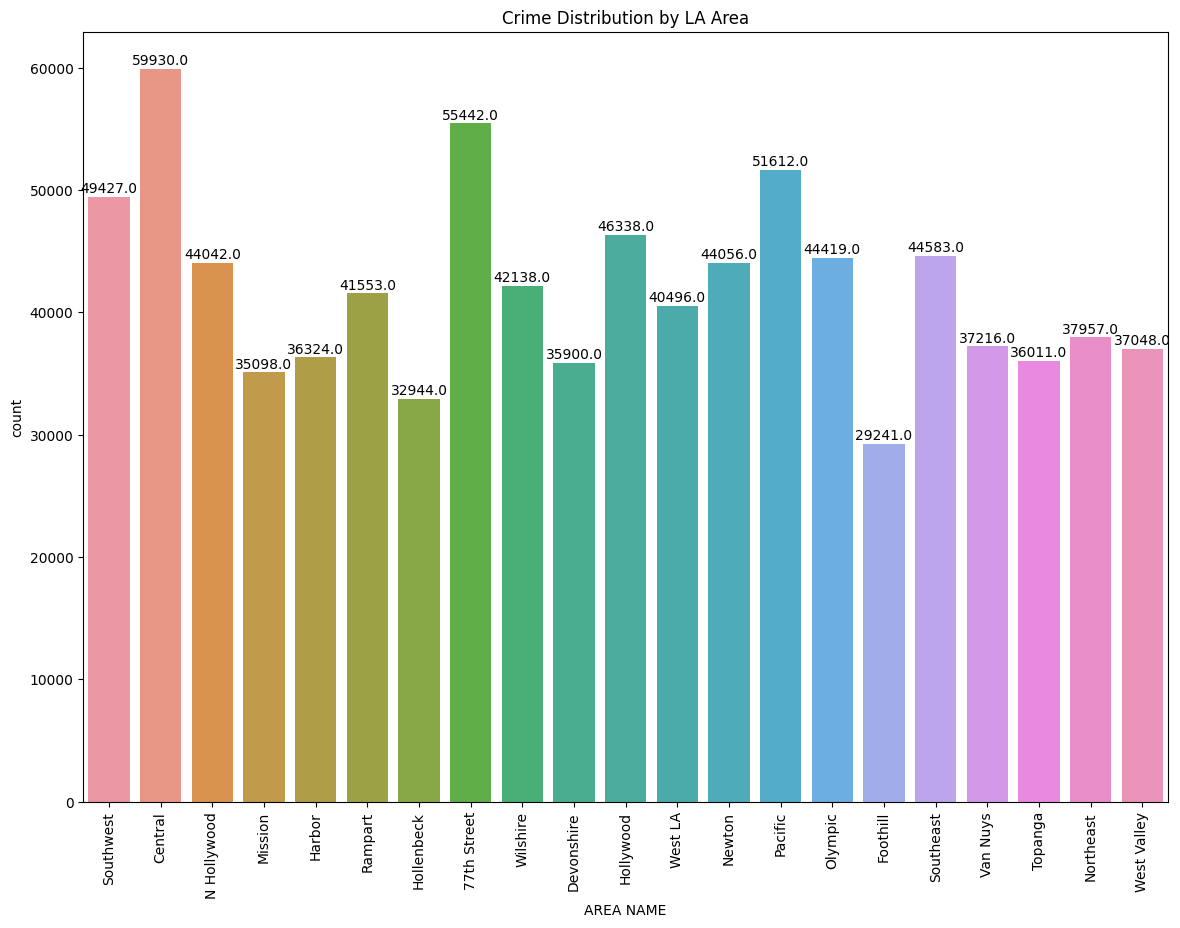

In [418]:
# Example: Crime Distribution by LA Area
plt.figure(figsize=(14, 10))
ax=sns.countplot(x="AREA NAME", data=crime)
plt.title("Crime Distribution by LA Area")
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 6), textcoords='offset points')
plt.show()

count    881775.000000
mean        500.990648
std         207.841176
min         110.000000
25%         331.000000
50%         442.000000
75%         626.000000
max         956.000000
Name: Crm Cd, dtype: float64


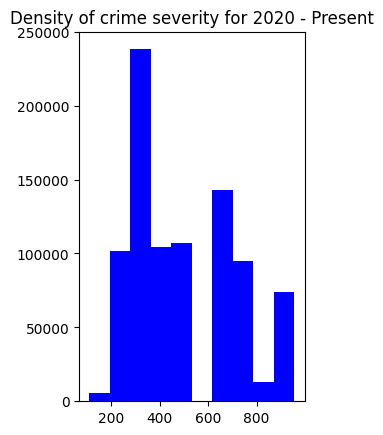

In [422]:
print(crime['Crm Cd'].describe())


plt.subplot(1, 2, 2)
plt.hist(crime['Crm Cd'], color='blue')
plt.title("Density of crime severity for 2020 - Present")
plt.show()



In [423]:
crime.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [424]:
# Renaming all the columns
crime.columns = ['RecNo','ReportDate','DateOCC','TimeOCC','Area','AreaName','DistrictNo','Part','CrimeCode','CrmDesc','Mocodes','VictAge','VictSex','VictRace','PremiseCd','PremiseDesc','WeaponCd','WeaponDesc','Status','StatusDesc','CrimeCd1','CrimeCd2','CrimeCd3','CrimeCd4','Location','CrossStreet','Lat','Lon']



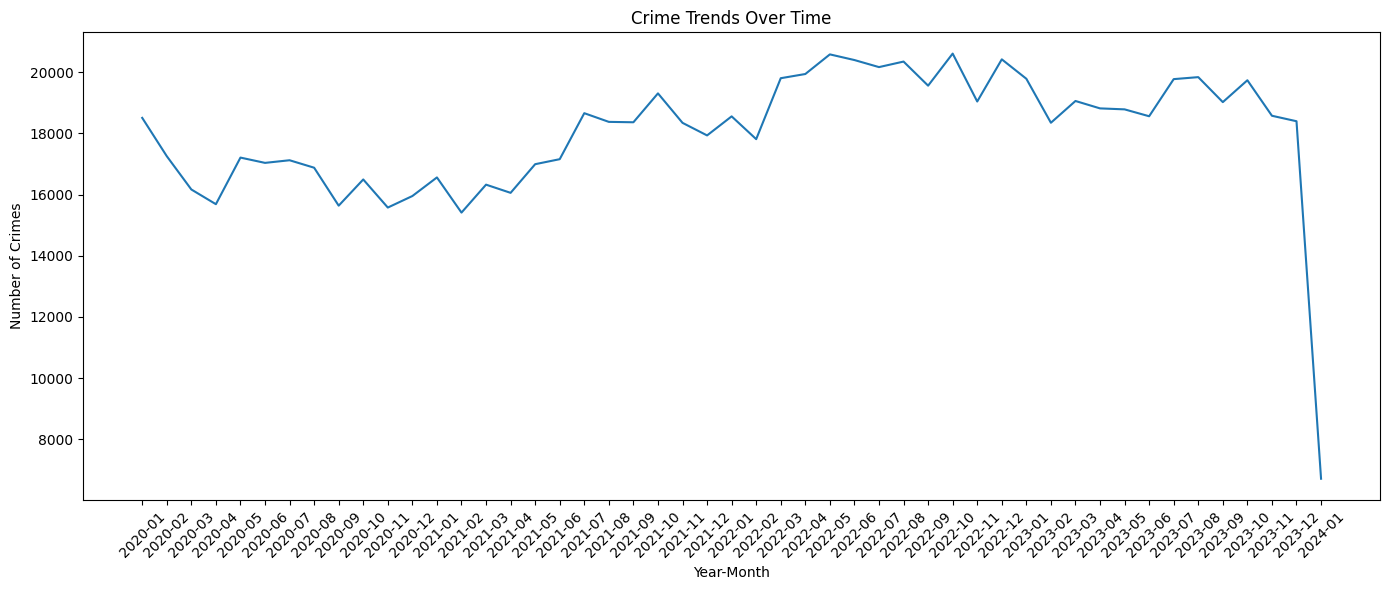

In [425]:
# Group by YearMonth and count the number of crimes
crime['DateOCC'] = pd.to_datetime(crime['DateOCC'])
crime['YearMonth'] = crime['DateOCC'].dt.to_period('M')
crime['YearMonth'] = crime['YearMonth'].astype(str)
crime
crime_trends =  crime.groupby('YearMonth').size().reset_index(name='Crime Count')

crime_trends

# Plotting
plt.figure(figsize=(14, 6))
sns.lineplot(x='YearMonth', y='Crime Count', data=crime_trends)
plt.title('Crime Trends Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [426]:
# Checking for null entries in our predictors
print(crime.isnull().sum())



RecNo               0
ReportDate          0
DateOCC             0
TimeOCC             0
Area                0
AreaName            0
DistrictNo          0
Part                0
CrimeCode           0
CrmDesc             0
Mocodes        122372
VictAge             0
VictSex        116363
VictRace       116371
PremiseCd          10
PremiseDesc       537
WeaponCd       575065
WeaponDesc     575065
Status              0
StatusDesc          0
CrimeCd1           11
CrimeCd2       817200
CrimeCd3       879589
CrimeCd4       881713
Location            0
CrossStreet    742349
Lat                 0
Lon                 0
YearMonth           0
dtype: int64


In [427]:
# Removing records with null values and illogical values
crime = crime.dropna(subset=['Mocodes','VictAge','VictSex','VictRace','PremiseDesc','PremiseCd'])
crime['WeaponCd'].fillna(0, inplace=True)

print(crime.isnull().sum())
print(crime.shape)



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


RecNo               0
ReportDate          0
DateOCC             0
TimeOCC             0
Area                0
AreaName            0
DistrictNo          0
Part                0
CrimeCode           0
CrmDesc             0
Mocodes             0
VictAge             0
VictSex             0
VictRace            0
PremiseCd           0
PremiseDesc         0
WeaponCd            0
WeaponDesc     452773
Status              0
StatusDesc          0
CrimeCd1           10
CrimeCd2       694377
CrimeCd3       756376
CrimeCd4       758496
Location            0
CrossStreet    641453
Lat                 0
Lon                 0
YearMonth           0
dtype: int64
(758558, 29)


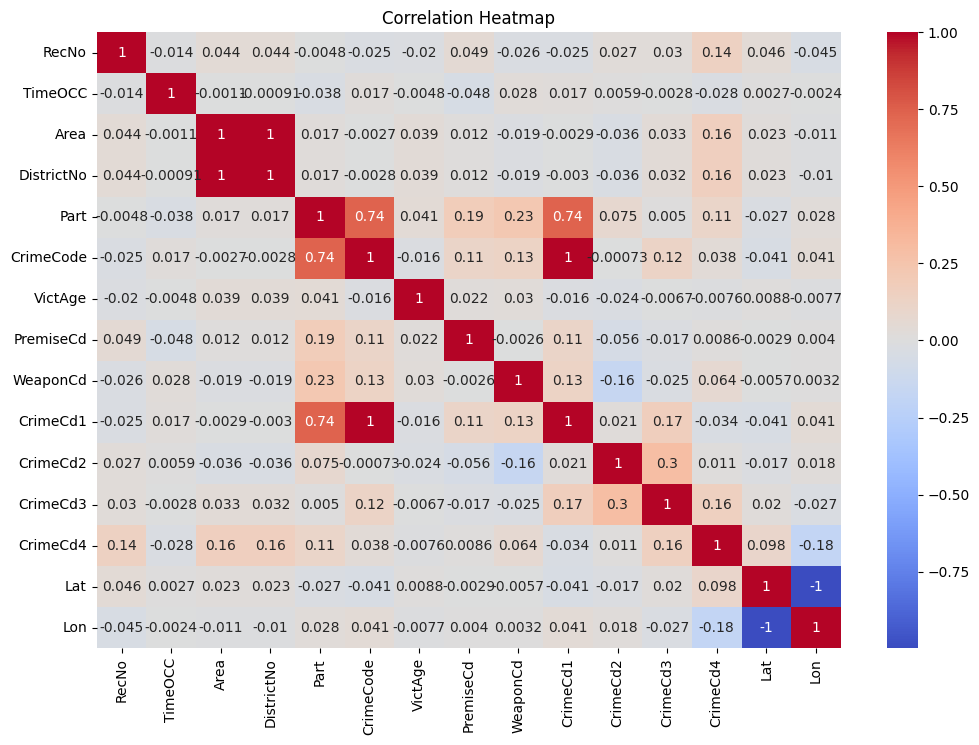

In [428]:
plt.figure(figsize=(12, 8))
sns.heatmap(crime.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [429]:
# Removing unknown records in VictSex and VictRace, Removing 0 in VictAge
crime = crime[(crime['VictSex'] != "X") & (crime['VictRace'] != "X") & (crime['VictAge'] != 0)]
print(crime.shape)

crime = crime.drop(columns=['CrimeCd2', 'CrimeCd3', 'CrimeCd4', 'Lat', 'Lon', 'RecNo', 'DateOCC', 'DistrictNo', 'ReportDate', 'CrossStreet', 'Location', 'StatusDesc', 'Status', 'WeaponDesc', 'Mocodes', 'CrmDesc', 'Part', 'AreaName'])



(641572, 29)


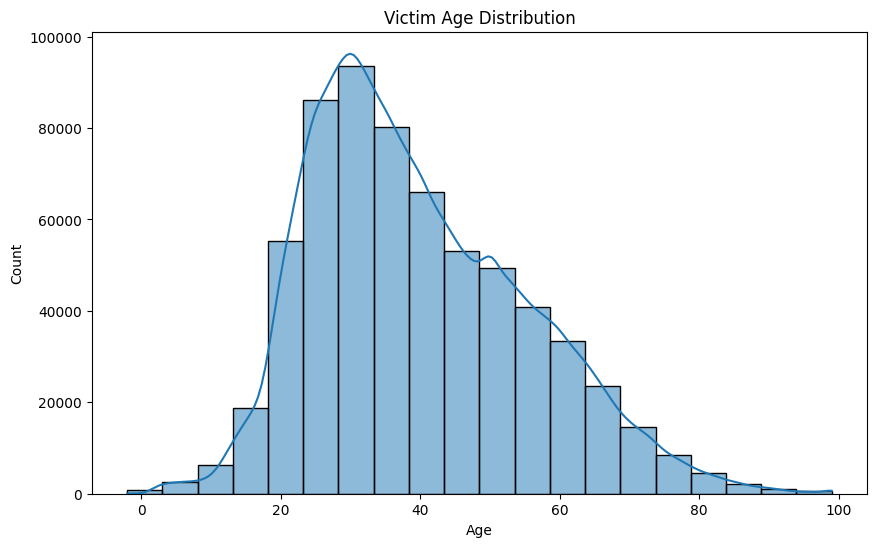

In [430]:
# Example: Victim Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(crime["VictAge"], bins=20, kde=True)
plt.title("Victim Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

Text(0.5, 1.0, 'Victim Gender Distribution')

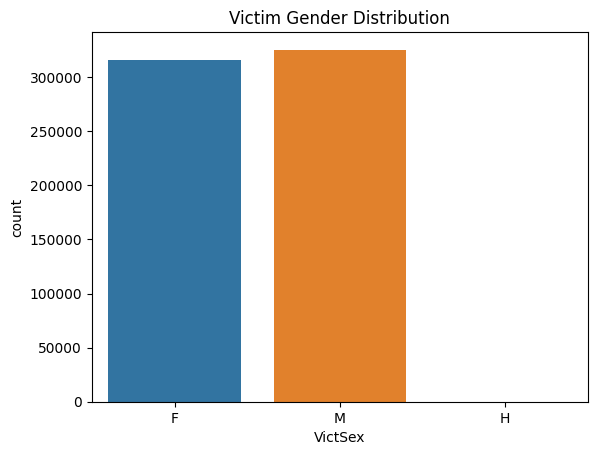

In [386]:
sns.countplot(x='VictSex', data=crime)
plt.title("Victim Gender Distribution")

In [431]:
# Transforming columns - CrimeCode
crime['Severity'] = np.where(crime['CrimeCode'] < 300, 'Severe', 'Non-Severe')
crime['Severity'] = pd.Categorical(crime['Severity'])

crime = crime.drop(columns=['CrimeCode', 'CrimeCd1'])



In [432]:
# Transforming columns - VictSex and Weapon
crime['Female'] = np.where(crime['VictSex'] == 'F', 'Yes', 'No')
crime['Female'] = pd.Categorical(crime['Female'])

crime['Weapon'] = np.where(crime['WeaponCd'] == 0, 'No', 'Yes')
crime['Weapon'] = pd.Categorical(crime['Weapon'])

crime = crime.drop(columns=['VictSex', 'WeaponCd'])



In [433]:
crime.head()

,TimeOCC,Area,VictAge,VictRace,PremiseCd,PremiseDesc,YearMonth,Severity,Female,Weapon
0,2230,3,36,B,501.0,SINGLE FAMILY DWELLING,2020-01,Non-Severe,Yes,Yes
1,330,1,25,H,102.0,SIDEWALK,2020-01,Non-Severe,No,Yes
3,1730,15,76,W,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",2020-01,Non-Severe,Yes,No
5,30,1,25,H,735.0,NIGHT CLUB (OPEN EVENINGS ONLY),2020-01,Severe,Yes,Yes
6,1315,1,23,H,404.0,DEPARTMENT STORE,2020-01,Non-Severe,No,No


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


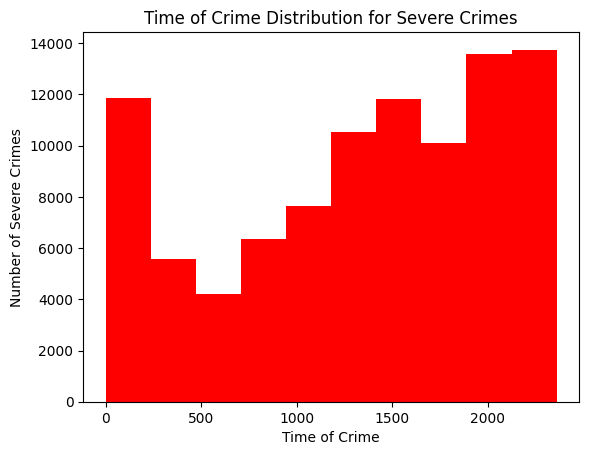

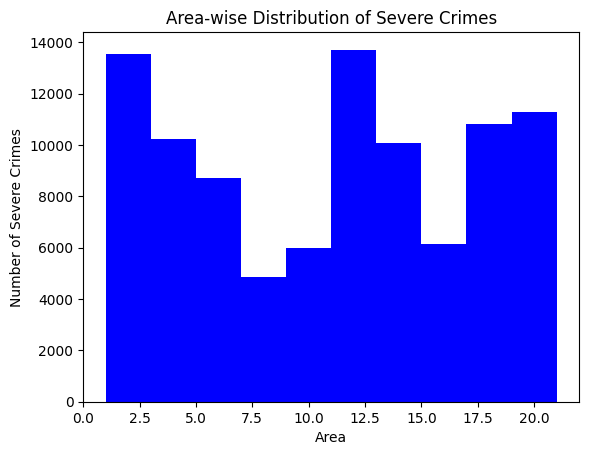

In [434]:
# Exploratory Data Analysis
severe_exploratory = crime[crime['Severity'] == 'Severe']
severe_exploratory['TimeOCC'] = pd.to_numeric(severe_exploratory['TimeOCC'])

# Time
plt.hist(severe_exploratory['TimeOCC'], color='red')
plt.xlabel('Time of Crime')
plt.ylabel('Number of Severe Crimes')
plt.title('Time of Crime Distribution for Severe Crimes')
plt.show()

# Area
plt.hist(severe_exploratory['Area'], color='blue')
plt.xlabel('Area')
plt.ylabel('Number of Severe Crimes')
plt.title('Area-wise Distribution of Severe Crimes')
plt.show()



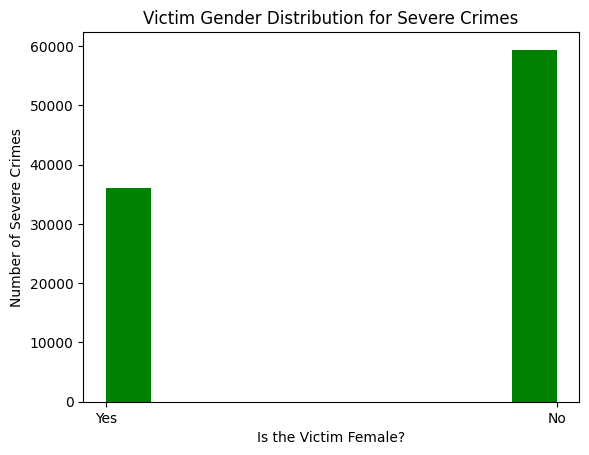

In [435]:
# Sex
plt.hist(severe_exploratory['Female'], color=['green'])
plt.xlabel('Is the Victim Female?')
plt.ylabel('Number of Severe Crimes')
plt.title('Victim Gender Distribution for Severe Crimes')
plt.show()



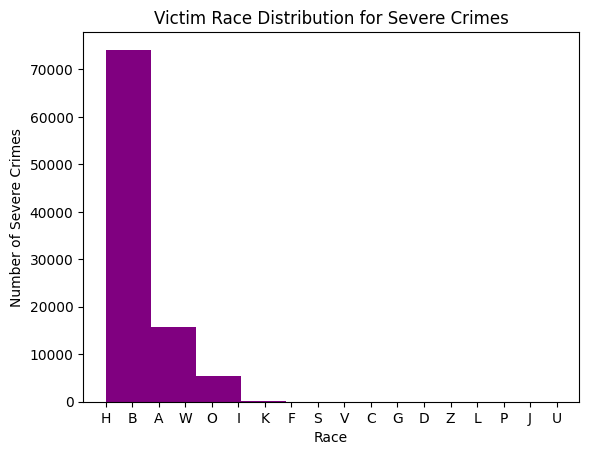

In [436]:
# Race
plt.hist(severe_exploratory['VictRace'], color='purple')
plt.xlabel('Race')
plt.ylabel('Number of Severe Crimes')
plt.title('Victim Race Distribution for Severe Crimes')
plt.show()



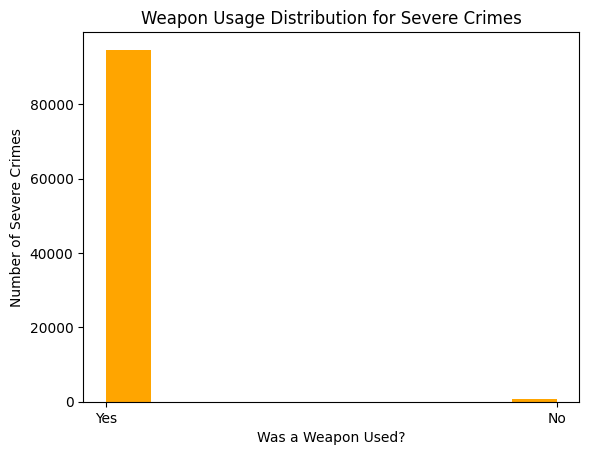

In [437]:
# Weapon
plt.hist(severe_exploratory['Weapon'], color=['orange'])
plt.xlabel('Was a Weapon Used?')
plt.ylabel('Number of Severe Crimes')
plt.title('Weapon Usage Distribution for Severe Crimes')
plt.show()




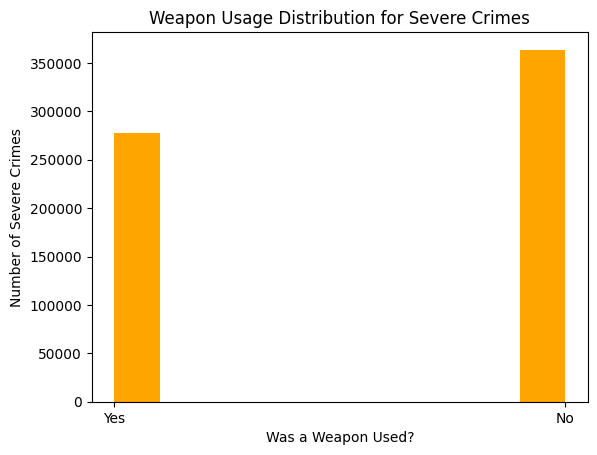

In [461]:
# Weapon

severe_exploratory1 = crime[crime['Severity'] != 'Severe']

plt.hist(crime['Weapon'], color=['orange']) 
plt.xlabel('Was a Weapon Used?')
plt.ylabel('Number of Severe Crimes')
plt.title('Weapon Usage Distribution for Severe Crimes')
plt.show()



In [446]:
# Modelling
X = crime.drop(columns=['Severity', 'YearMonth'])
y = crime['Severity']

categorical_features = ['Area', 'VictRace', 'PremiseDesc', 'Female', 'Weapon']
numeric_features = ['TimeOCC', 'VictAge', 'PremiseCd']

In [447]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: One-hot encoding categorical features and scaling numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

In [449]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_preprocessed, y_train)
dt_pred = dt_model.predict(X_test_preprocessed)


In [450]:
# Printing the classification report
print("Decision Tree Classifier Report:")
print(classification_report(y_test, dt_pred))

Decision Tree Classifier Report:
              precision    recall  f1-score   support

  Non-Severe       0.90      0.90      0.90    109271
      Severe       0.44      0.44      0.44     19044

    accuracy                           0.83    128315
   macro avg       0.67      0.67      0.67    128315
weighted avg       0.83      0.83      0.83    128315



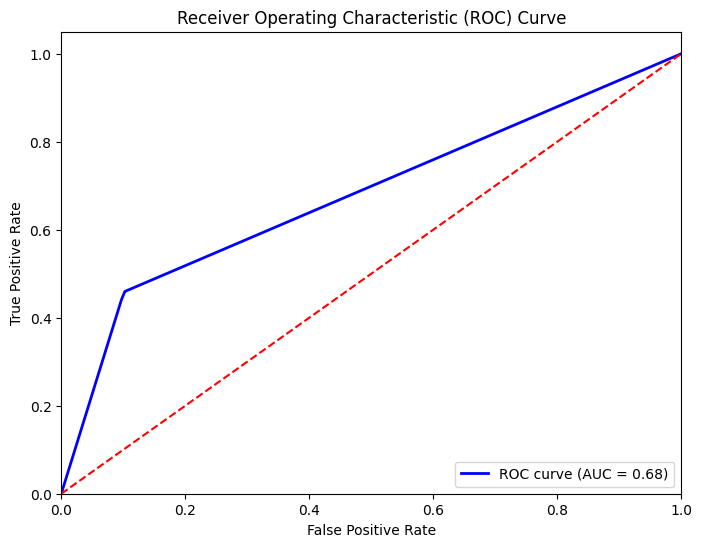

In [451]:
# Predict probabilities for positive class
y_prob = dt_model.predict_proba(X_test_preprocessed)[:, 1]

# Calculate false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='Severe')

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [452]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_preprocessed, y_train)
lr_pred = lr_model.predict(X_test_preprocessed)


In [453]:
print("Logistic Regression Classifier Report:")
print(classification_report(y_test, lr_pred))

Logistic Regression Classifier Report:
              precision    recall  f1-score   support

  Non-Severe       0.90      0.96      0.93    109271
      Severe       0.61      0.38      0.46     19044

    accuracy                           0.87    128315
   macro avg       0.75      0.67      0.70    128315
weighted avg       0.86      0.87      0.86    128315



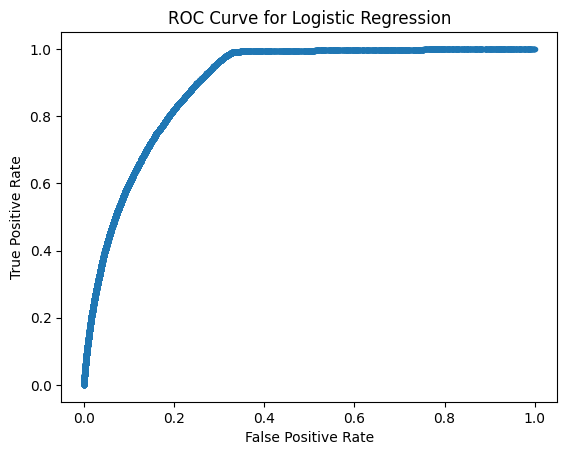

AUC for Logistic Regression: 0.8967405408436027


In [454]:
# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Convert categorical labels to binary labels
y_test_binary = y_test.map({'Non-Severe': 0, 'Severe': 1})

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, lr_probs)

# Calculate AUC
lr_auc = roc_auc_score(y_test_binary, lr_probs)

# Plot ROC curve
plt.plot(fpr, tpr, marker='.')
plt.title('ROC Curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print("AUC for Logistic Regression:", lr_auc)
